In [1]:
import sys
import os
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import models_mae

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def prepare_model_ImNet(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint, strict=False)
    print(msg)
    return model

def prepare_model_from_torchhub(model_name='deit_base_patch16_224'):
    model = torch.hub.load('facebookresearch/deit:main', model_name)
    return model



def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

In [3]:
torch.device("cuda:1")

device(type='cuda', index=1)

### Load an image

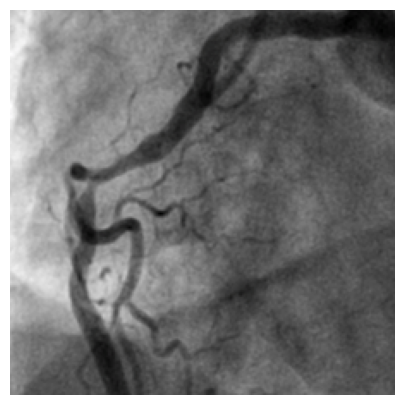

In [4]:
# load an image
img_url = './FAME2_data/FOLD_0/train/VOCE_0/110.png' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(img_url)
img = img.resize((224, 224))
img = np.array(img)[:,:,:3] / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [16]:
chkpt_dir_cfp = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/pretrained/RETFound_cfp_weights.pth'
chkpt_dir_oct = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/pretrained/RETFound_oct_weights.pth'
chkpt_dir_xca = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/pretrained/RETFound_xca_weights.pth'
chkpt_dir_fame2 = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/pretrained/RETFound_fame2_weights.pth'
chkpt_dir_imNet = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/pretrained/mae_visualize_vit_large.pth'
chkpt_dir_imNet_fame2 = '/data/mkondrac/foundation_model_cardio/code/RETFound_MAE/output_dir_pretrain_ImNet/checkpoint-300.pth'

model_mae_cfp = prepare_model(chkpt_dir_cfp, 'mae_vit_large_patch16')
model_mae_oct = prepare_model(chkpt_dir_oct, 'mae_vit_large_patch16')
model_mae_xca = prepare_model(chkpt_dir_xca, 'mae_vit_large_patch16')
model_mae_fame2 = prepare_model(chkpt_dir_fame2, 'mae_vit_large_patch16')
model_vit_imNet = prepare_model(chkpt_dir_imNet, 'mae_vit_large_patch16')
model_vit_imNet_fame2 = prepare_model(chkpt_dir_imNet_fame2, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE FAME2 reconstruction:


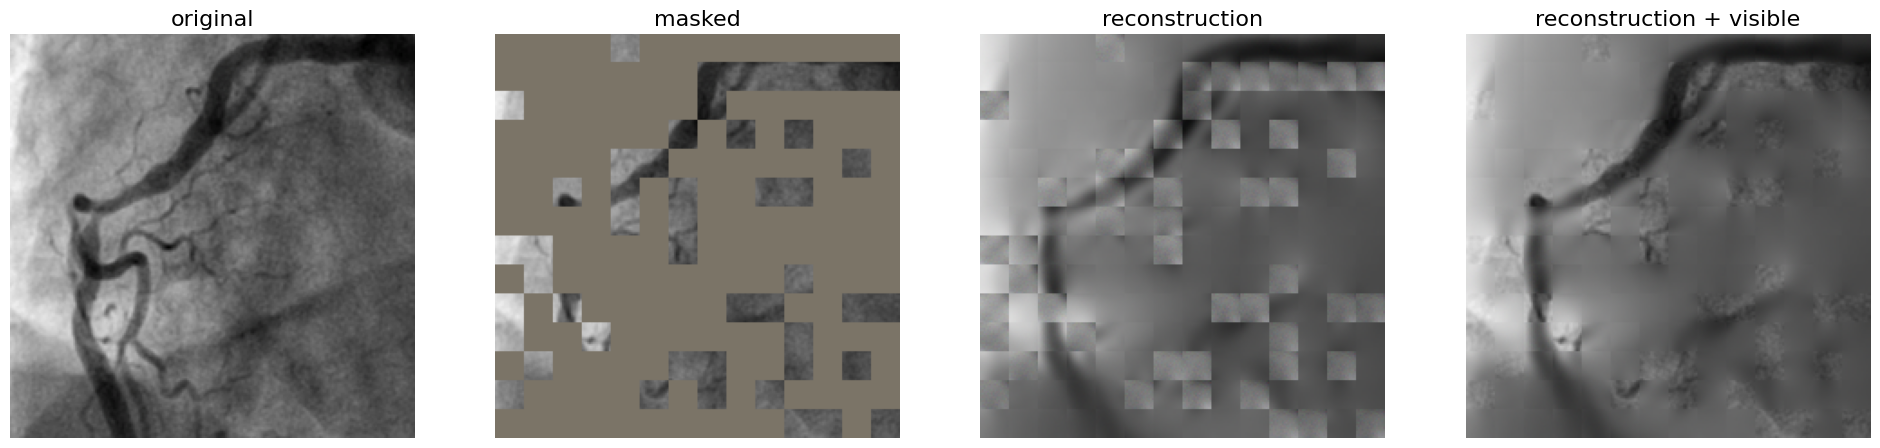

In [ ]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(10)
print('MAE RETFound FAME2 reconstruction:')
run_one_image(img, model_mae_fame2)

MAE RETFound OCT reconstruction:


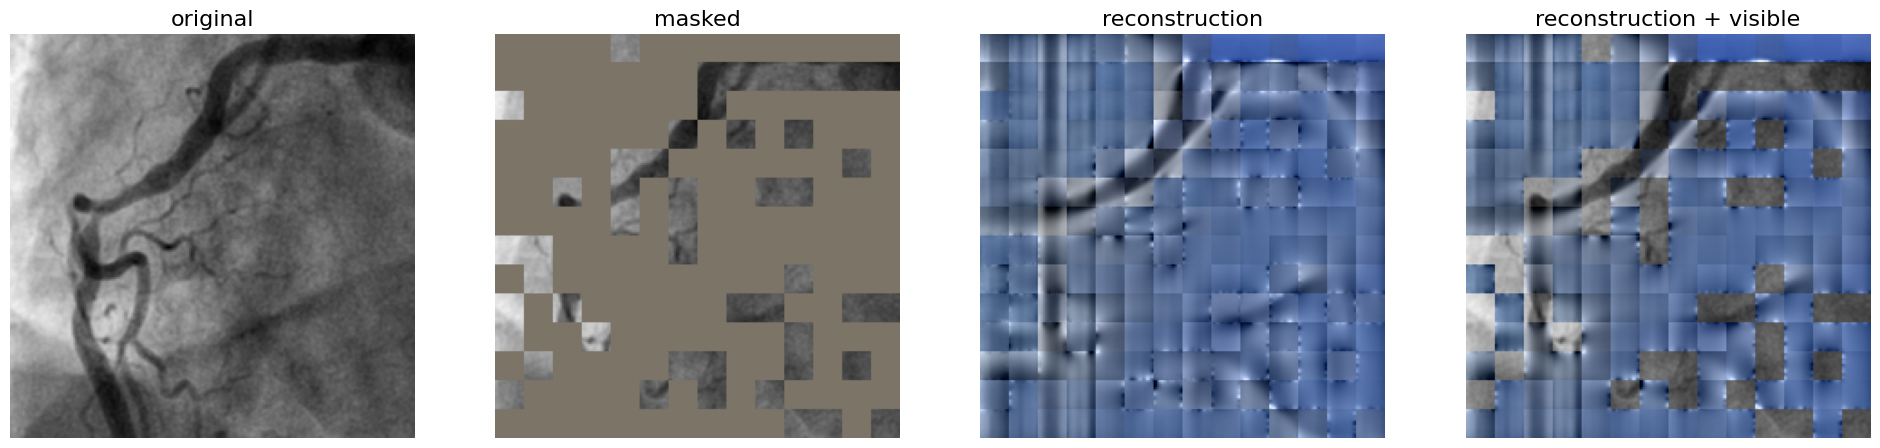

In [17]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(10)
print('MAE RETFound OCT reconstruction:')
run_one_image(img, model_mae_oct)

MAE RETFound CFP reconstruction:


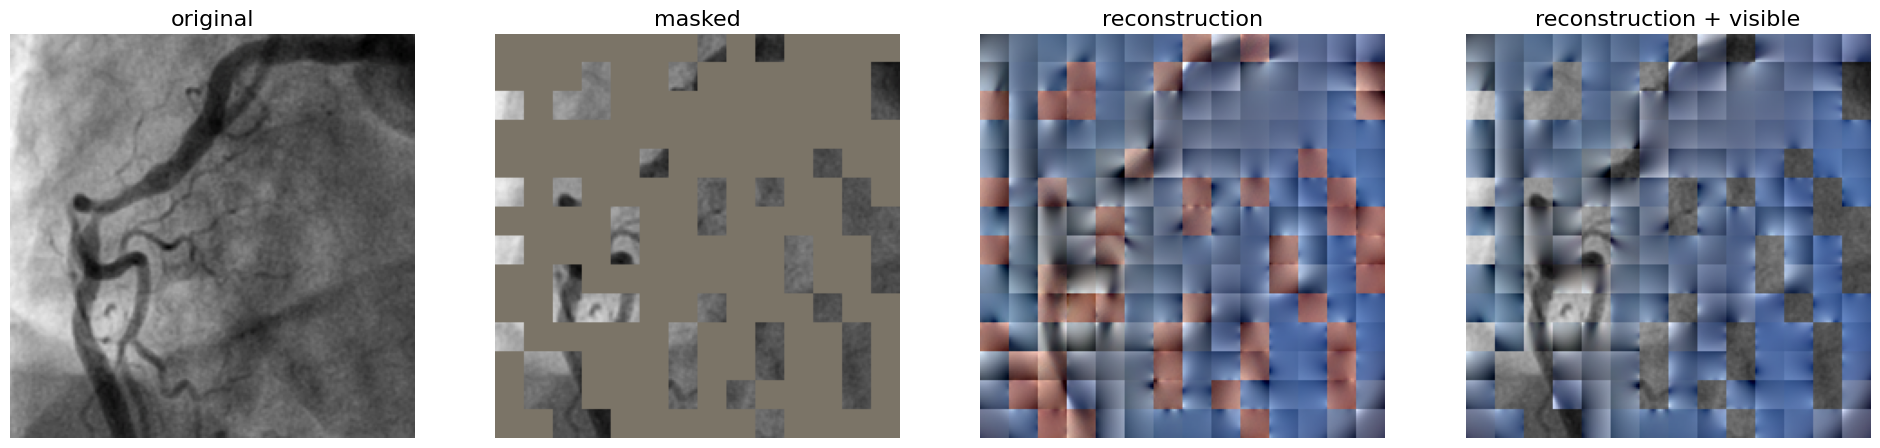

In [ ]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE RETFound CFP reconstruction:')
run_one_image(img, model_mae_cfp)

MAE ViT ImNet reconstruction:


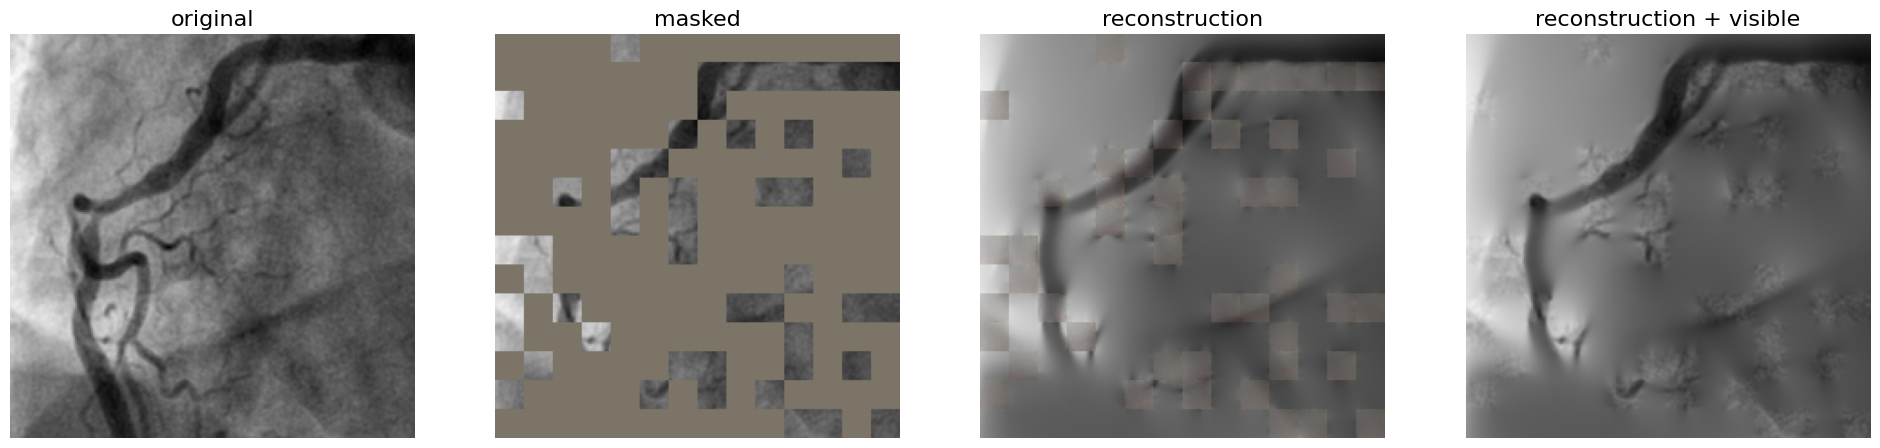

In [10]:
torch.manual_seed(10)
print('MAE ViT ImNet reconstruction:')
run_one_image(img, model_vit_imNet)

MAE ViT ImNet FAME2 reconstruction:


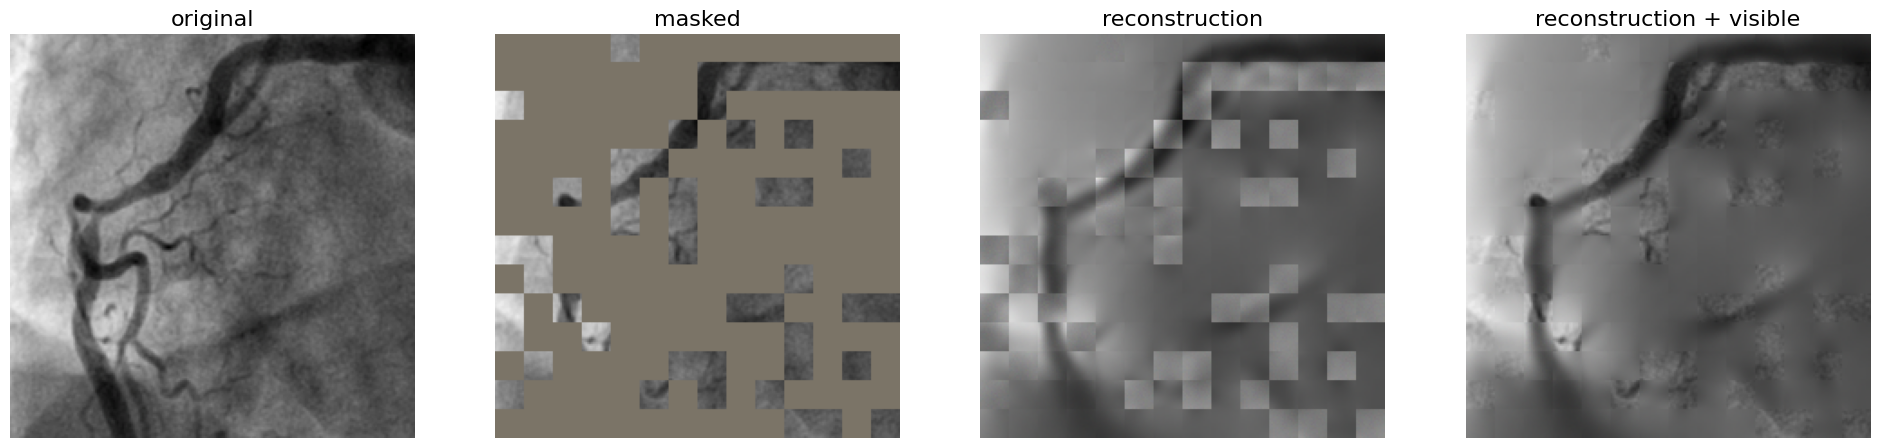

In [11]:
torch.manual_seed(10)
print('MAE ViT ImNet FAME2 reconstruction:')
run_one_image(img, model_vit_imNet_fame2)